In [2]:

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
#from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import miscLidar as mscLid
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
from constsLidar import *
import pandas as pd
#import ARLreader as Ar

datetime.time(datetime.now())

datetime.time(15, 57, 45, 955028)

In [3]:
def gdas2radiosonde(src_file,dst_file,
        col_names = ['PRES','HGHT','TEMP','UWND',
                     'VWND','WWND','RELH','TPOT','WDIR','WSPD']):
	'''
	Helper function that converts a gdas file from TROPOS server, to a simple txt.
	The resulting file is without any prior info, and resembles the table format
	of a radiosonde file (see class: RadiosondeProfile)
	:param src_file: source file name
	:param dst_file: destination file name
	:param col_names: column names of the final table
	'''
	import pandas as pd
	from pandas.api.types import is_numeric_dtype

	data_src = pd.read_fwf(src_file,skiprows=[0,1,2,3,4,5,6,8],
	                       delimiter="\s+",skipinitialspace=True).dropna()
	# converting any kind of blanc spaces to zeros
	for col in data_src.columns:
		if not is_numeric_dtype(data_src[col]):
			data_src[col]= pd.core.strings.str_strip(data_src[col])
			data_src[col]= data_src[col].replace('','0').astype('float64')
	data_src.columns = col_names
	data_src.to_csv(dst_file,index=False,sep='\t',na_rep='\t')
	# TODO: add warning if failed
def extract_date_time(path,format_filename,format_times):
	# Extracting datetime from file name using a formatter string.
	#
	# Usage:
	# create a formatter string: format_filename=  r'-(.*)_(.*)-(.*)-.*.txt'
	# Call the function:        f time_stamp = extract_date_time(soundePath,r'40179_(.*).txt',['%Y%m%d_%H'])
	# Output:
	#       time_stamps - A list of datetime objects
	import re
	filename = os.path.basename(path)
	#print(filename)
	matchObj = re.match(format_filename, filename, re.M|re.I)
	# print(matchObj)
	time_stamps=[]
	for fmt_time,grp in zip(format_times,matchObj.groups()):
		time_stamps.append(datetime.strptime(grp,fmt_time))
	return time_stamps
def calc_sigma_profile_df(row,lambda_um = 532.0,indx_n= 'sigma'):
	'''
	Returns pd series of extinction profile [1/m] from a radiosonde dataframe containing the
	columns:['PRES','TEMPS',RELHS]. The function applies on rows of the radiosonde df.
	:param row: row of radiosonde df
	:param lambda_um: wavelength in [um], e.g, for green lambda_um = 532.0 [um]
	:param indx_n: index name, the column name of the result. The default is 'sigma'
	but could be useful to get profiles for several hours each have a different index name
	(e.g., datetime object of measuring time of the radiosonde as datetime.datetime(2017, 9, 2, 0, 0))
	:return: pd series of extinction profile [1/m]
	'''
	return pd.Series([rayleigh_scattering.alpha_rayleigh(wavelength= lambda_um,
	                                       pressure=row['PRES'],
	                                       temperature=row['TEMPS'],
	                                       C=385.0, rh=row['RELHS'])],index=[indx_n])
def calc_beta_profile_df(row,lambda_um = 532.0,ind_n= 'beta'):
	'''
	Returns pd series of backscatter profile from a radiosonde dataframe containing the
	columns:['PRES','TEMPS',RELHS]. The function applies on rows of the radiosonde df.
	:param row: row of radiosonde df
	:param lambda_um: wavelength in [um], e.g, for green lambda_um = 532.0 [um]
	:param indx_n: index name, the column name of the result. The default is 'beta'
	but could be useful to get profiles for several hours each have a different index name
	(e.g., datetime object of measuring time of the radiosonde as datetime.datetime(2017, 9, 2, 0, 0))
	:return: pd series of backscatter profile [1/sr*m]
	'''
	return pd.Series([rayleigh_scattering.beta_pi_rayleigh(wavelength= lambda_um,
	                                       pressure=row['PRES'],
	                                       temperature=row['TEMPS'],
	                                       C=385.0, rh=row['RELHS'])],index=[ind_n])

In [4]:
'''set day,location'''
lon = 35.0
lat = 32.8
day_date = datetime(2017,9,1)

'''Set paths to parents folder '''
lidar_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\data\level1a\PollyXT_TROPOS'
gdas_parent_folder = 'H:\data_haifa\DATA FROM TROPOS\GDAS\haifa'


In [5]:
lidar_day_folder = os.path.join(lidar_parent_folder,day_date.strftime("%Y\%m\%d"))
os.listdir(lidar_day_folder)
bsc_pattern = os.path.join(lidar_day_folder,"*_att_bsc.nc")
bsc_paths = sorted(glob.glob(bsc_pattern))
#bsc_paths
profile_pattern = os.path.join(lidar_day_folder,"*[0-9]_profiles.nc")
profile_paths = sorted(glob.glob(profile_pattern))
#profile_paths


In [6]:
from pathlib import Path
'''set source gdas files '''
# TODO: Add namings and existing path validation (print warnings and errors)
src_folder = os.path.join(os.getcwd(),'gdas')
gdas_curd_pattern = 'haifa_{}_*_{}_{}.gdas1'.format(day_date.strftime('%Y%m%d'),lat,lon)
gdas_nxtd_pattern = 'haifa_{}_00_{}_{}.gdas1'.format((day_date+timedelta(days=1)).strftime('%Y%m%d'),lat,lon)
gdas_src_paths = sorted(glob.glob(os.path.join(src_folder,gdas_curd_pattern)))
gdas_src_paths.append(os.path.join(src_folder,gdas_nxtd_pattern))

'''set dest txt files'''
dst_folder = os.path.join(os.getcwd(),'gdas_txt')
# TODO: Add validation and indicate if folder already existed or created now (print warnings and errors)
Path(dst_folder).mkdir(parents=True, exist_ok=True)
gdas_dst_paths = [sub.replace(src_folder, dst_folder).replace('gdas1','txt') for sub in gdas_src_paths]
for (src_file,dst_file) in zip(gdas_src_paths,gdas_dst_paths):
	gdas2radiosonde(src_file,dst_file)
	print('\n Done conversion src: ',src_file,'dst: ',dst_file)
	#sanity check
	#data_dst =pd.read_csv(dst_file,delimiter="\s+")
	#print(data_dst)

# TODO : set 'gdas_src_paths' and 'src_folder' according to 'start_date' and 'end_date' -
#  for conversion of a big chunk of gdas files. See examples below.
# TODO : set 'gdas_dst_paths' in similar way. Such that the folders of gdas and txt files will have same tree
#  (or just save it in the same folders?)
'''gdas_month_folder = os.path.join(gdas_parent_folder, day_date.strftime("%Y\%m"))
#print (os.path.exists(gdas_month_folder))

gdas_cur_pattern = 'haifa_{}_*_{}_{}.gdas1'.format(day_date.strftime('%Y%m%d'),lat,lon)
gdas_next = 'haifa_{}_00_{}_{}.gdas1'.format((day_date+timedelta(days=1)).strftime('%Y%m%d'),lon,lat)
gdas_pattern  = os.path.join(gdas_month_folder,gdas_cur_pattern)
gdas_paths = sorted(glob.glob(gdas_pattern))
gdas_paths.append(os.path.join(gdas_month_folder,gdas_next))
#gdas_file = Ar.fname_from_date(day_date)
#print('name of input file ', gdas_pattern)'''


 Done conversion src:  C:\Users\addalin\Dropbox\Lidar\code\tmp\haifa_20170901_00_32.8_35.0.gdas1 dst:  C:\Users\addalin\Dropbox\Lidar\code\tmp2\haifa_20170901_00_32.8_35.0.txt

 Done conversion src:  C:\Users\addalin\Dropbox\Lidar\code\tmp\haifa_20170901_03_32.8_35.0.gdas1 dst:  C:\Users\addalin\Dropbox\Lidar\code\tmp2\haifa_20170901_03_32.8_35.0.txt

 Done conversion src:  C:\Users\addalin\Dropbox\Lidar\code\tmp\haifa_20170901_06_32.8_35.0.gdas1 dst:  C:\Users\addalin\Dropbox\Lidar\code\tmp2\haifa_20170901_06_32.8_35.0.txt

 Done conversion src:  C:\Users\addalin\Dropbox\Lidar\code\tmp\haifa_20170901_09_32.8_35.0.gdas1 dst:  C:\Users\addalin\Dropbox\Lidar\code\tmp2\haifa_20170901_09_32.8_35.0.txt

 Done conversion src:  C:\Users\addalin\Dropbox\Lidar\code\tmp\haifa_20170901_12_32.8_35.0.gdas1 dst:  C:\Users\addalin\Dropbox\Lidar\code\tmp2\haifa_20170901_12_32.8_35.0.txt

 Done conversion src:  C:\Users\addalin\Dropbox\Lidar\code\tmp\haifa_20170901_15_32.8_35.0.gdas1 dst:  C:\Users\ad

'gdas_month_folder = os.path.join(gdas_parent_folder, day_date.strftime("%Y\\%m"))\n#print (os.path.exists(gdas_month_folder))\n\ngdas_cur_pattern = \'haifa_{}_*_{}_{}.gdas1\'.format(day_date.strftime(\'%Y%m%d\'),lat,lon)\ngdas_next = \'haifa_{}_00_{}_{}.gdas1\'.format((day_date+timedelta(days=1)).strftime(\'%Y%m%d\'),lon,lat)\ngdas_pattern  = os.path.join(gdas_month_folder,gdas_cur_pattern)\ngdas_paths = sorted(glob.glob(gdas_pattern))\ngdas_paths.append(os.path.join(gdas_month_folder,gdas_next))\n#gdas_file = Ar.fname_from_date(day_date)\n#print(\'name of input file \', gdas_pattern)'

In [7]:
'''physical parameters'''
lambda_um =  LAMBDA.G*1e+9
dr = 7.47e-3       # Height resolution dr~= 7.5e-3[km] (similar to the lidar height resolution)
top_height = 22.48566 # Top height for interest signals (similar to the top height of the lidar measurement)
heights= np.arange(min_height,top_height,dr) #setting heights for interpolation of gdas/radiosonde inputs
print(heights.shape,min_height)
df_sigma = pd.DataFrame()
df_beta = pd.DataFrame()

for dst_file in gdas_dst_paths:
	df_sonde = RadiosondeProfile(dst_file).get_df_sonde(heights)
	#df_sonde = sondeprofile.get_df_sonde(heights)
	time = extract_date_time(dst_file,r'haifa_(.*)_32.8_35.0.txt',['%Y%m%d_%H'])[0]
	'''Calculating molecular profiles from temperature and pressure'''
	res = df_sonde.apply(calc_sigma_profile_df,axis = 1,args=(lambda_um,time,),result_type='expand').astype('float64')
	df_sigma[res.columns]=res
	res = df_sonde.apply(calc_beta_profile_df,axis = 1,args=(lambda_um,time,),result_type='expand').astype('float64')
	df_beta[res.columns]=res

(2980,) 0.229


float

<Figure size 432x288 with 0 Axes>

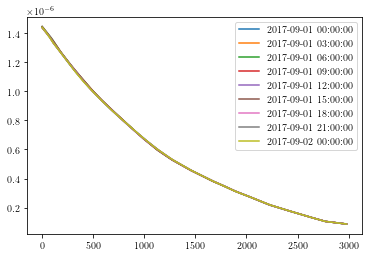

'\nvis_molecular = True\nstime = extract_date_time(dst_file,r\'haifa_(.*)_32.8_35.0.txt\',[\'%Y%m%d_%H\'])[0].strftime(\'%Y/%m/%d %H:%M\')\n\nif vis_molecular:\n    lData  = {\'x\':[heights],\'y\':[sigma_mol],\'lableX\': \'Heights [km]\',\n              \'lableY\': r"$\x08oldsymbol\\sigma\\quad[\rm 1/m]$",\n              \'stitle\':r\'$\x08oldsymbol\\sigma_{{\rm mol}}^{{\\lambda={0:.0f}}}$\'.format(lambda_um)}\n    rData  = {\'x\':[heights],\'y\':[beta_mol],\'lableX\': \'Heights [km]\',\n              \'lableY\': r\'$\x08oldsymbol\x08eta\\quad[\rm{{1}/m \\cdot {sr}]}$\',\n              \'stitle\':r\'$\x08oldsymbol\x08eta_{{\rm mol}}^{{\\lambda={0:.0f}}}$\'.format(lambda_um)}\n    stitle= r\'Molecular profiles {}\'.format(stime)\n    [fig, axes] = mscLid.visCurve(lData,rData,stitle)\n    plt.show()\t'

In [8]:
'''Visualize molecular profiles'''
plt.figure()
df_beta.plot()
plt.show()

# TODO: adjust the func  mscLid.visCurve (used bellow) to signals in the dataframe (instead of showing a single profile , show all of them with the relevant time)
'''
vis_molecular = True
stime = extract_date_time(dst_file,r'haifa_(.*)_32.8_35.0.txt',['%Y%m%d_%H'])[0].strftime('%Y/%m/%d %H:%M')

if vis_molecular:
    lData  = {'x':[heights],'y':[sigma_mol],'lableX': 'Heights [km]',
              'lableY': r"$\boldsymbol\sigma\quad[\rm 1/m]$",
              'stitle':r'$\boldsymbol\sigma_{{\rm mol}}^{{\lambda={0:.0f}}}$'.format(lambda_um)}
    rData  = {'x':[heights],'y':[beta_mol],'lableX': 'Heights [km]',
              'lableY': r'$\boldsymbol\beta\quad[\rm{{1}/m \cdot {sr}]}$',
              'stitle':r'$\boldsymbol\beta_{{\rm mol}}^{{\lambda={0:.0f}}}$'.format(lambda_um)}
    stitle= r'Molecular profiles {}'.format(stime)
    [fig, axes] = mscLid.visCurve(lData,rData,stitle)
    plt.show()	'''

In [9]:
# TODO: check 2D interpolation in transformation (see link below)
'''@ https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

instead of append, load the profiles to dataframe and then create an image.
treat every row of the dataframe as a time series. so the interpolation is done per row.
from 00:00,03:00,06:00,09:00,12:00,15:00,18:00,21:00,24:00 to 00:00-24:00 with intervals of 30 sec'''

'@ https://machinelearningmastery.com/resample-interpolate-time-series-data-python/\n\ninstead of append, load the profiles to dataframe and then create an image.\ntreat every row of the dataframe as a time series. so the interpolation is done per row.\nfrom 00:00,03:00,06:00,09:00,12:00,15:00,18:00,21:00,24:00 to 00:00-24:00 with intervals of 30 sec'

In [10]:
''' read radiosonde at 00:00 and 12:00 and 00:00 (of the day after)'''
## radiosonde download and analysis from cameranetwork

''' read gdas data for 00:00, 03:00, 06:00, 09:00 ,12:00, 15:00 , 18:00 ,21:00, 24:00'''
## use: https://github.com/martin-rdz/ARLreader


## AERONET : https://aeronet.gsfc.nasa.gov/cgi-bin/data_display_aod_v3?site=Technion_Haifa_IL&nachal=0&year=2017&month=5&day=19&aero_water=0&level=3&if_day=0&if_err=0&place_code=10&DATA_TYPE=-999&year_or_month=3
## it is possible to merge with Terra MODIS or Aqua MODIS -
# / TODO: locate the function that does donwload of sunphotometer data to cameranetwork (maybe Shubi knows this)
# / TODO: ask about the relevant product from MODIS to our porpose.
''' Interpolate on molecular profiles on a 2D grid 00:00-23:59 '''

' Interpolate on molecular profiles on a 2D grid 00:00-23:59 '

In [11]:
# for the followings :
# X = {lidar measurement (range corrected) molecular (range corrected)}
# Y = {lidar const, reference height [min,max]}